In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

kappa = 25.0
chi = 0.65
kerr = 0.005
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff =10.0
n0 = 31.
tau_0 = 0.398
res_amp_scaling = 1/0.43
nR = 0.05
snr_scale_factor = 8.4
gamma_I = 1/26.
photon_gamma = 1/300.
num_t1 = 8.
init_fid = 1. - 1e-3

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid
)

t1: 0.04496951345228329
t3: 0.028613955541745277
baseline smoothness: 0.00017194172971083256
rough a3r smoothness: 0.01797226666666668
min of normal action: -1.0
min of smoothed action: -0.9934035799688061


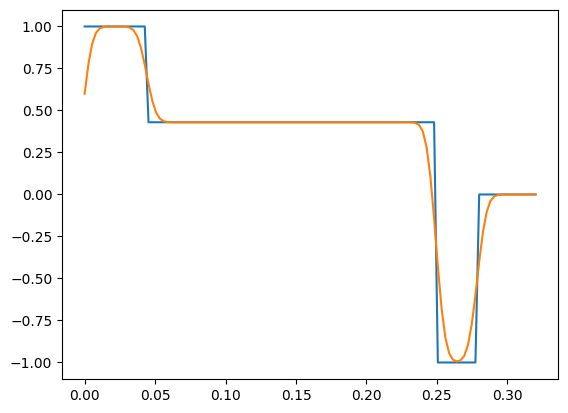

In [4]:
params = env.default_params
kernel = params.gauss_kernel
example_action = env.dummy_a3r_waveform()
ts_action = env.ts_action

print(f"t1: {env.t1()}")
print(f"t3: {env.t3()}")

smoothed_action = jnp.convolve(example_action, kernel, mode='same')
smoothness = env.calculate_batch_smoothness(smoothed_action)
og_smoothness = env.calculate_batch_smoothness(example_action)

print(f"baseline smoothness: {smoothness}")
print(f"rough a3r smoothness: {og_smoothness}")

print(f"min of normal action: {jnp.min(example_action)}")
print(f"min of smoothed action: {jnp.min(smoothed_action)}")

plt.plot(ts_action, example_action, label='example')
plt.plot(ts_action, smoothed_action, label='smoothed')
plt.show()

In [5]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
global update: 100
mean batch reward: [13.51214361 13.32112173 13.40788632 13.49131215 13.23559581 13.5528032
 13.38076096 13.49371245]
mean batch pF: [1.52491451 1.53333588 1.53005678 1.53588976 1.53009111 1.53758076
 1.53726125 1.53057325]
mean batch photon: [27.53047943 27.75257111 27.41880798 27.84024811 27.70610428 27.87425804
 27.96632576 27.7411747 ]
mean batch photon time: [0.15623995 0.15473779 0.15697267 0.15491561 0.15465687 0.15695839
 0.15657852 0.15498929]
mean batch smoothness: [0.00013745 0.00010421 0.0001445  0.00010808 0.0001378  0.00014453
 0.00013702 0.0001437 ]
max reward obtained: [14.45410074 14.44934261 14.44197278 14.42936479 14.3905852  14.40416846
 14.33542684 14.45638741]
pF at max: [1.49770136 1.55164559 1.51844283 1.41662155 1.53940223 1.54497451
 1.51887673 1.49130628]
photon at max: [28.81086922 28.99625015 26.87408829 25.50676918 29.64515495 27.04110336
 27.18871689 27.54099464]
photon time of max: [0.14792095 0.14666667 0

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/interpreters/mlir.py(2366): _wrapped_callback
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/interpreters/pxla.py(1151): __call__
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/profiler.py(336): wrapper
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/pjit.py(1185): _pjit_call_impl_python
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/pjit.py(1229): call_impl_cache_miss
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/pjit.py(1245): _pjit_call_impl
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/core.py(935): process_primitive
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/core.py(447): bind_with_trace
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/core.py(2740): bind
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/pjit.py(168): _python_pjit_helper
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/pjit.py(257): cache_miss
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/jax/_src/traceback_util.py(179): reraise_with_filtered_traceback
  /var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_57121/2207674835.py(5): <module>
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/ipkernel.py(429): do_execute
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/kernelbase.py(766): execute_request
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/kernelbase.py(424): dispatch_shell
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/kernelbase.py(518): process_one
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/kernelbase.py(529): dispatch_queue
  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py(80): _run
  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py(601): run_forever
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/tornado/platform/asyncio.py(205): start
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel/kernelapp.py(739): start
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/traitlets/config/application.py(1077): launch_instance
  /Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/ipykernel_launcher.py(17): <module>
  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py(87): _run_code
  /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py(197): _run_module_as_main
